# Preparado de los Datos
A lo largo de este notebook se cubre la tercera fase de la metodología CRIPS-DM, en este caso la preparación dec los datos

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. <span style="color:#66FF99;">**Preparación de los Datos (Data Preparation)** </span> 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. **Modelado (Modeling)**  
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.



Con los datos seleccionados del conjunto de datos, pasamos a generar nuevos datos adicionales que nos permitan entrenar el modelo con una cuantia de datos aun mayor dadas las clases seleccionadas, además de extraer nuevas características de nuestras imágemes para obtener mejores resultados con los modelos a usar. Es por ello que este apartado se divide en dos etapas:

1. Muestreado y ajuste de las imágenes

2. Generación de imágenes derivadas de las actuales

3. Uso de modelos fundacionales

### 1. Sampleado del conjunto de datos

Este primer apartado abarca la corrección de aquellas deficiencias enconrtadas a lo largo del notebook anterior, relativo al análisis exploratorio de los datos.

A lo largo de esta primera parte del noteobook se procederá a la realización del sampleo de instancias del dataset inicial, dando como salida en este caso un dataset nativo de tensorflow `tf.dataset`, que permitirá que el entrenamierto del modelo sea lo más rápido posible. Los objetivos de este apartado serán varios:

- La eliminación las máscaras demasiado pequeñas, para facilitar el aprendijaze del modelo

- La obtención de  un conjunto de entrenamieto mucho más balanceado

In [20]:
from pathlib import Path
from utils import  load_yaml_file, download_zip
import os

import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
import matplotlib.patches as mpatches


Se cargan las clases objetivo de nuestro fichero `yaml`, almacenadas en este para ganarntizar la consistencia y evitar errores en la experimentación.

In [21]:
yaml = load_yaml_file()


In [22]:
objetives = yaml["objetive_classes"]
objetives

objetives = objetives[:3]

N_CLASSES = len(objetives) + 1

In [23]:
DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=33.93s)
creating index...
index created!


In [24]:
TRAIN_IMAGES_PATH = DIR_TRAIN_IMGS 

Se buscan obtener los ids de las categorias a capturar, almacenadas en categories:

In [25]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}


In [26]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con las clases coindicentes son  {len(img_ids)}")

Las imagenes con las clases coindicentes son  68346


Del conjunto que contienen al menos una clase, definimos un umbral minimo y vemos si la suma de pixeles que supone la totalidad de las máscaras es o no significativa para nuestro conjunto de entrenamiento

Se define una función que, usando la API de COCO genere un `np.array` de la instancia, que alimentará el `tf.dataset`.
Antes del guardado definitivo, se generan funciones que permitan visualizar la correcta generación de las máscaras

In [27]:


def mask_generator(class_id,image_id, display = True, threshold = 200):
    #print("image image_id")
    ann_ids = coco.getAnnIds(imgIds=image_id, catIds=[class_id], iscrowd=None)

    image_info = coco.loadImgs(image_id)[0]

    height, width = image_info['height'], image_info['width']

    img_path = os.path.join(TRAIN_IMAGES_PATH,  image_info['file_name'])

    composite_mask  = np.zeros((height, width), dtype=np.uint8)

    if not ann_ids:
        #print("no anotation")
        # Reporesentamos (mascara vacía)
        if(display):
            original_image = cv2.imread(img_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)        
            _ , axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(original_image)
            axs[0].axis('off')
            axs[0].set_title('Imagen')
            
            axs[1].imshow(composite_mask, cmap='gray')
            axs[1].axis('off')
            axs[1].set_title('Máscara agrupando por clase')
            plt.show()        
        return composite_mask

   

    for ann in ann_ids:

        #print("anotation found")

        ann = coco.loadAnns(ann)[0]

        #print(ann)
           
        mask = coco.annToMask(ann)

        #print(f"Tamaño de la mascara {np.sum(mask)}")

        # Control de elementos demasiado pequeños de cara a generar el ground truth
        
        if(np.sum(mask)>threshold):
            #print("over number of pixels")

            if( mask.shape == composite_mask.shape):
                composite_mask = np.maximum(composite_mask, mask * 255)
            else:
                pass
                #print("some error ocurredx in the load of the mask")
    
    # Ahora representamos de forma gráfica de forma opcional (segun el parametro pasado  )

    if(display):
        original_image = cv2.imread(img_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)        
        _ , axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(original_image)
        axs[0].axis('off')
        axs[0].set_title('Imagen')
        
        axs[1].imshow(composite_mask, cmap='gray')
        axs[1].axis('off')
        axs[1].set_title('Máscara agrupando por clase')
        plt.show()

    # La máscara la devolvemsos para guardarla como np array
    #print("mask of shape ", composite_mask.shape)
    return composite_mask


Además, se genera una función que genera de una imagen la clase `fondo`, aquella que se corresponderá con cada uno de los píxeles no etiquetados en la imagen, y que permitirá entrenar el modelo de forma correcta.

In [28]:
def  empty_mask_generator(image_id):

    image_info = coco.loadImgs(image_id)[0]

    height, width = image_info['height'], image_info['width']

    composite_mask  = np.zeros((height, width), dtype=np.uint8)

    return composite_mask

A continuación, se obtiene el etiquetado final de las imágenes mediante estas funciones, haciendo uso de un primer submuestreo de 10 imágenes para comprobar que el procedimiento seguido ha sido el correcto:

In [29]:


results = []

for image_id in img_ids[:10]:

    image_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(TRAIN_IMAGES_PATH, image_info['file_name'])
    original_image = cv2.imread(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    mascaras = []

    background = empty_mask_generator(image_id)

    for cat in category_info_objetive.keys():


        mask = mask_generator(image_id=image_id, class_id= cat, display= False )
        background = np.add(background, mask)

        mascaras.append(mask)

    background = np.where(background!= 0 , 0 , 1)
    mascaras.append(background)

    mascara_imagen = np.stack(mascaras, axis=-1)

    results.append(mascara_imagen)





Además, se construye una función que nos ayudará a representar de forma gráfica las imágenes junto con sus máscaras:

In [30]:
def plot_image_with_masks(image_id, masks, categories_ids):
    image_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(TRAIN_IMAGES_PATH, image_info['file_name'])

    original_image = cv2.imread(img_path)
    print(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    fig , axs = plt.subplots(3, 4, figsize=(15, 10))
    axs = axs.flatten() 
    
    axs[0].imshow(original_image)
    axs[0].axis('off')
    axs[0].set_title('Image')
    
    #print(f"We dhave {masks.shape[-1]}, {masks.shape}")
    print("mi range is ", masks.shape)
    for idx in range(masks.shape[-1]):
        
        # if idx >= len(axs) - 1:  # Avoid index out-of-range
        #     break

        
        mask = masks[:,:,idx]
        axs[idx + 1].imshow(mask)
        axs[idx + 1].axis('off')
        axs[idx + 1].set_title(f'{categories_ids[idx]}' if idx < len(categories_ids) else "background")
    

    
    [fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

    plt.tight_layout()
    plt.show()


Función usada para representar la máscara en su formato One-Hot Encoded

In [31]:
COLORS = ['gray', 'red','blue','green','yellow', 'orange','purple','pink', 'brown','cyan','white',"blue"]

COLORS_DICT = {index:color for index, color in enumerate(COLORS)}



def plot_image_with_masks_one_hot_encoded(image_id, masks, dict_colors = COLORS_DICT ):

    image_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(TRAIN_IMAGES_PATH, image_info['file_name'])

    original_image = cv2.imread(img_path)
    print(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    fig , axs = plt.subplots(1, 2, figsize=(15, 10))
    axs = axs.flatten() 
    
    axs[0].imshow(original_image)
    axs[0].axis('off')
    axs[0].set_title('Image')
    
    #print(f"We dhave {masks.shape[-1]}, {masks.shape}")
    print("mi range is ", masks.shape)
    composite_mask  = np.zeros(( masks.shape[0],  masks.shape[1]), dtype=np.uint8)
                               
    for idx in range(masks.shape[-1]):
        mask_values = np.where(masks[:,:,idx]!=0, idx, 0)
        composite_mask = np.add(composite_mask, mask_values)
        
   
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[1].imshow(composite_mask, cmap=plt.cm.get_cmap('tab10', len(dict_colors)))
    axs[1].axis('off')

    # Create legend
    legend_patches = [mpatches.Patch(color=color, label=f'Class {idx}') for idx, color in dict_colors.items()]
    axs[1].legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.show()


Image with id 262145
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000262145.jpg
mi range is  (427, 640, 4)


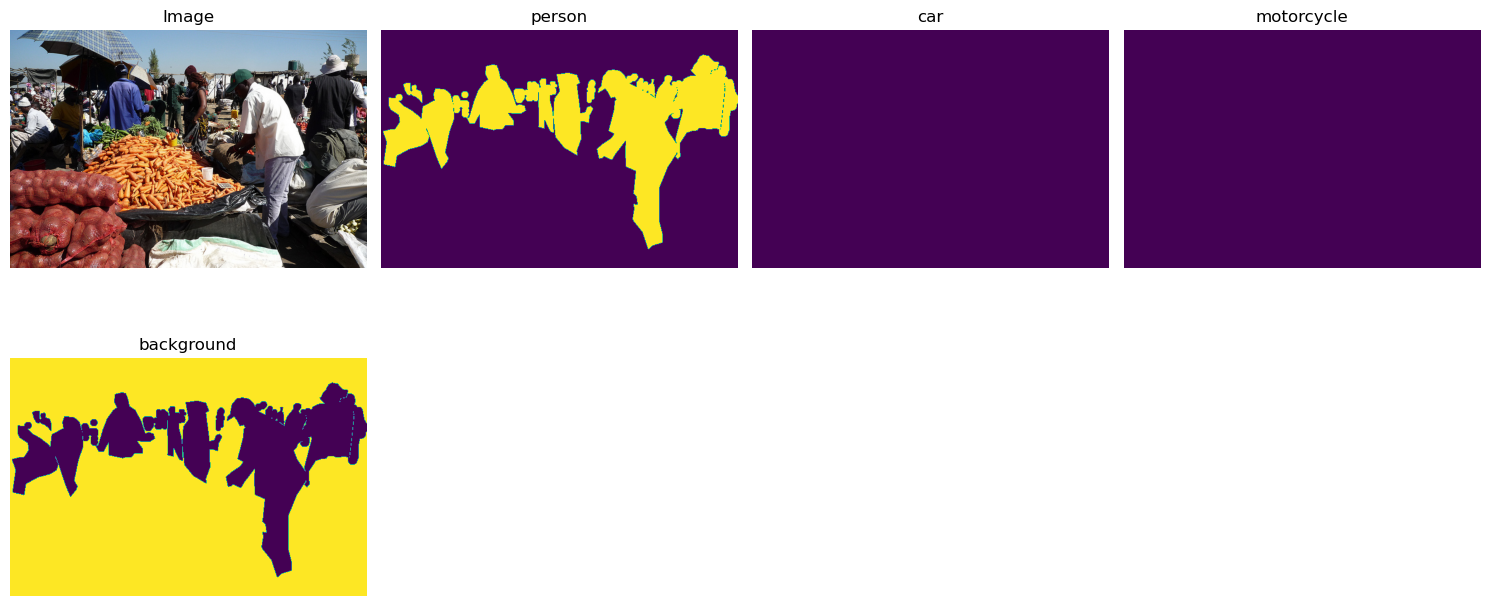

 

Image with id 262146
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000262146.jpg
mi range is  (640, 480, 4)


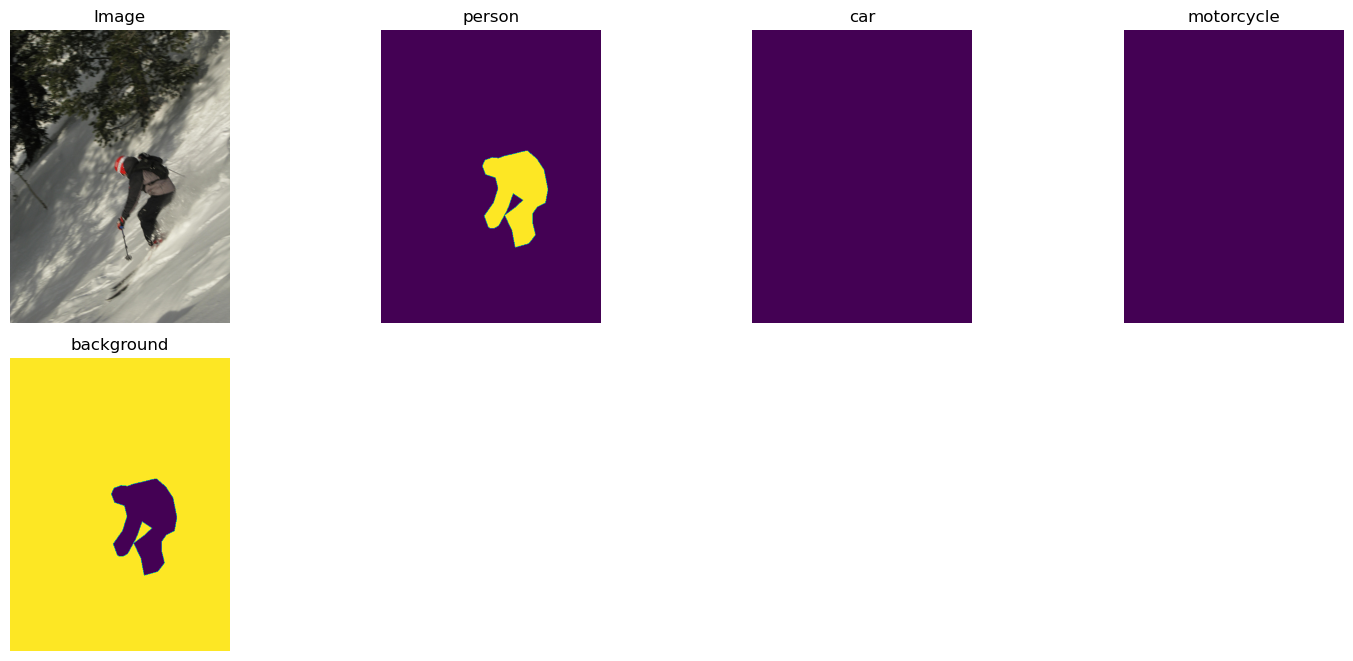

 

Image with id 524291
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000524291.jpg
mi range is  (426, 640, 4)


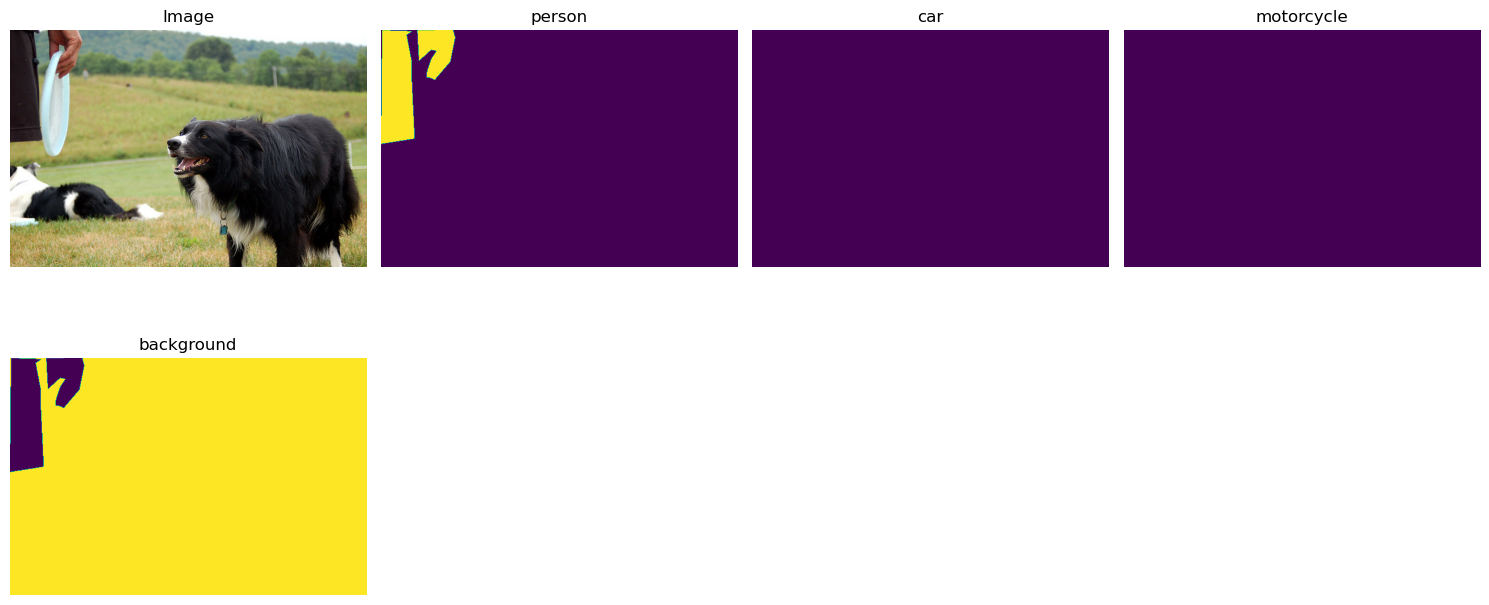

 

Image with id 262148
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000262148.jpg
mi range is  (512, 640, 4)


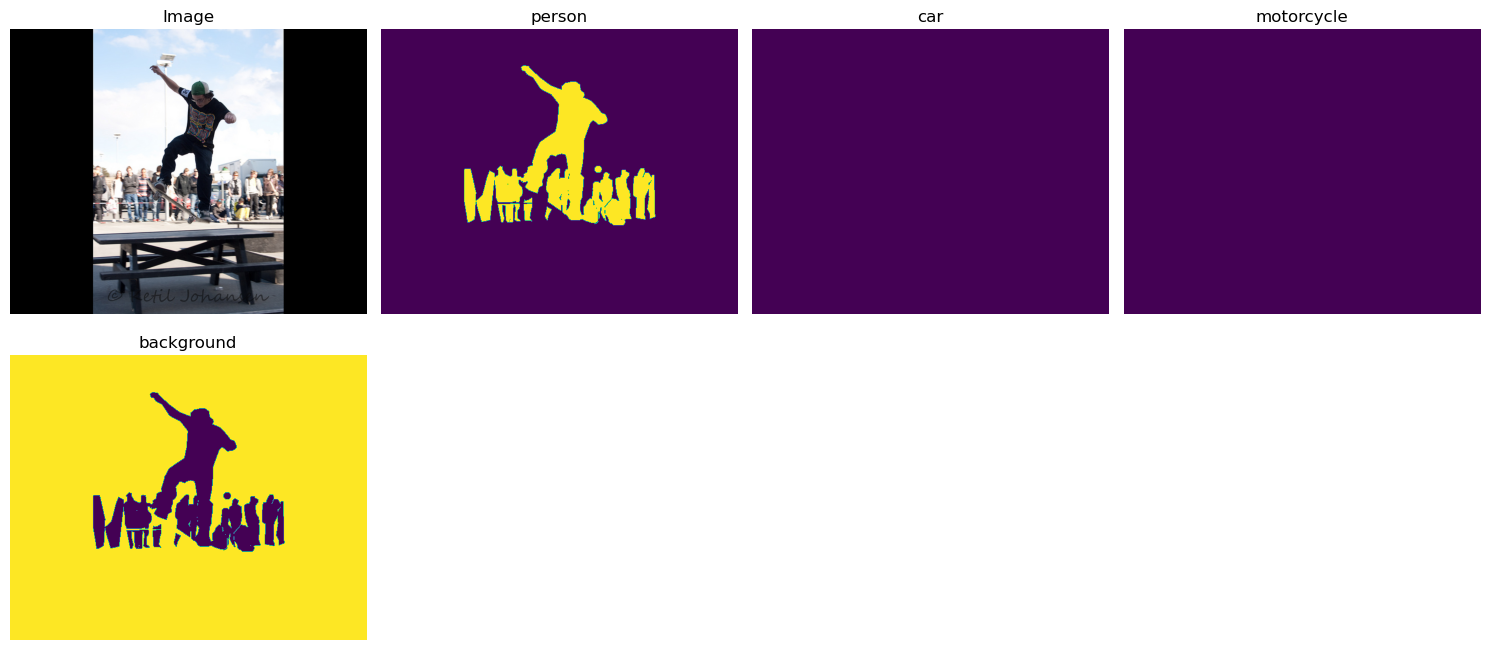

 

Image with id 393223
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000393223.jpg
mi range is  (480, 640, 4)


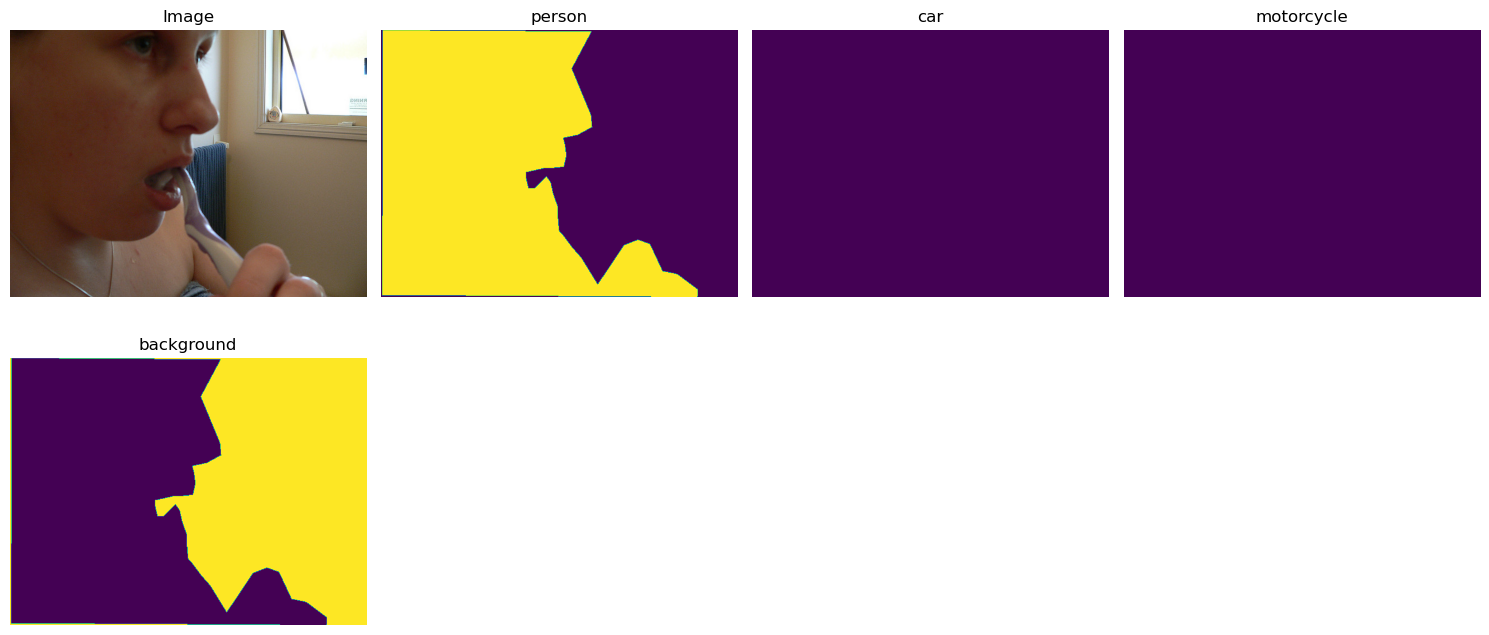

 

Image with id 393224
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000393224.jpg
mi range is  (640, 427, 4)


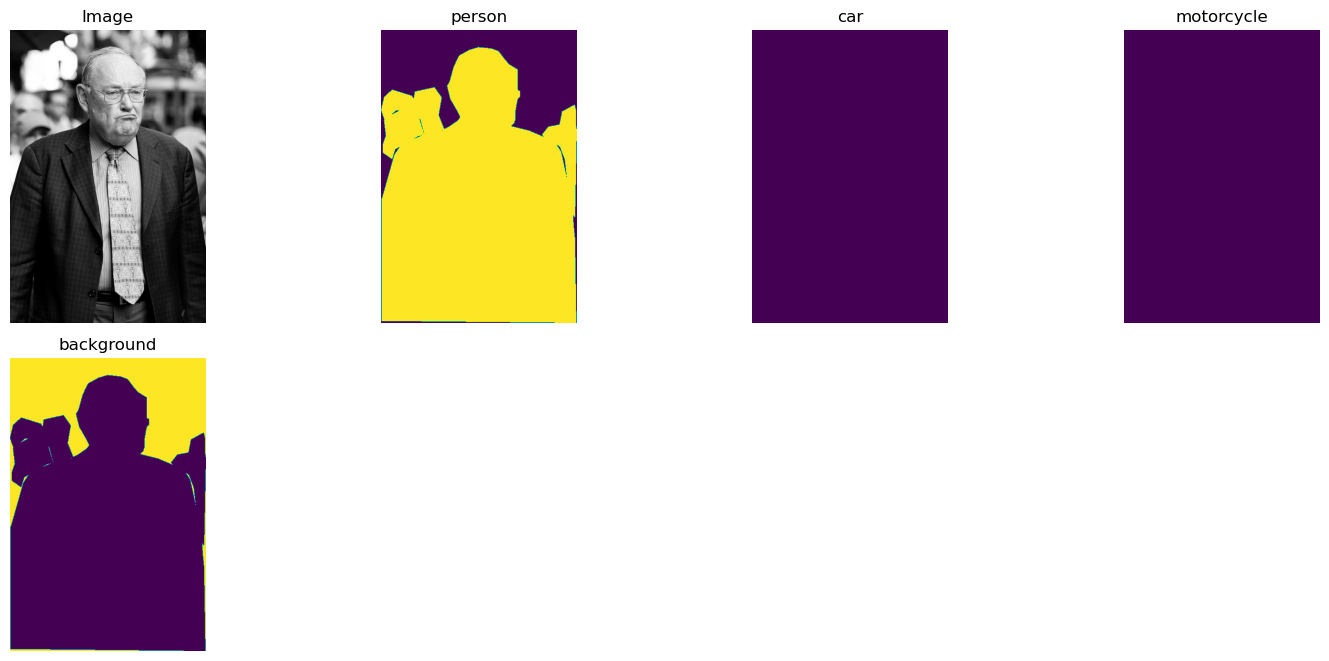

 

Image with id 524297
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000524297.jpg
mi range is  (446, 640, 4)


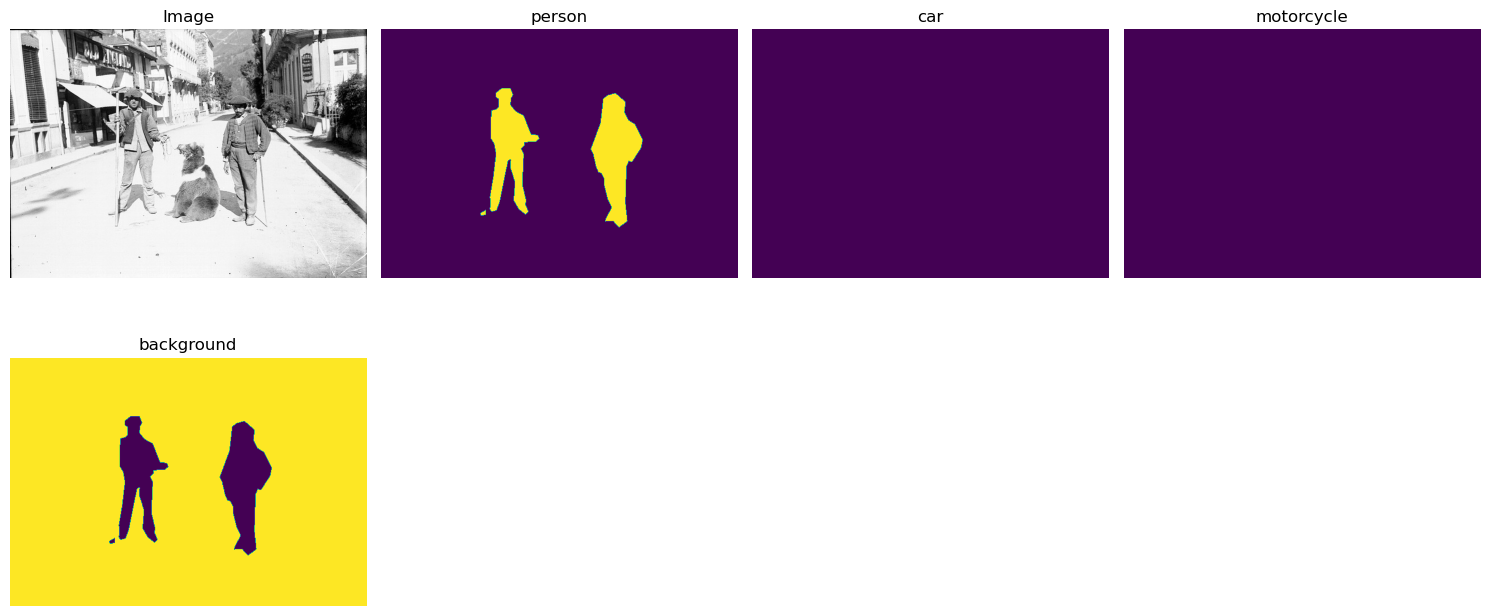

 

Image with id 393227
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000393227.jpg
mi range is  (640, 427, 4)


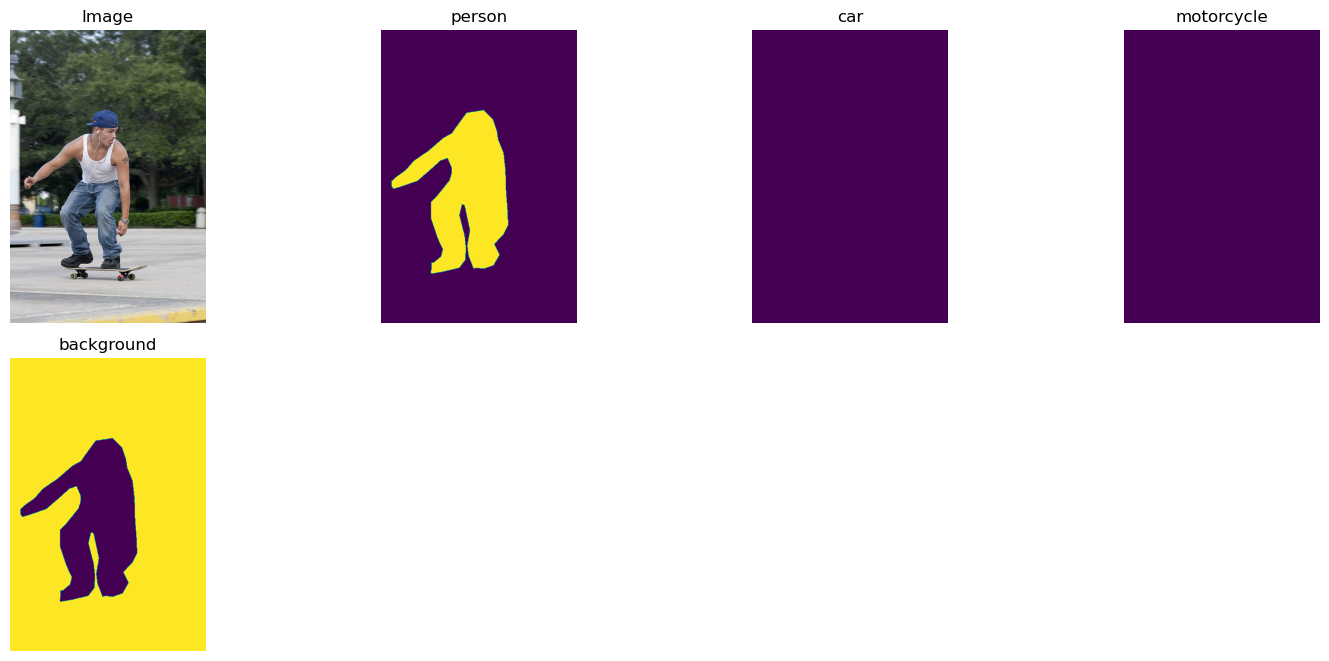

 

Image with id 131084
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000131084.jpg
mi range is  (426, 640, 4)


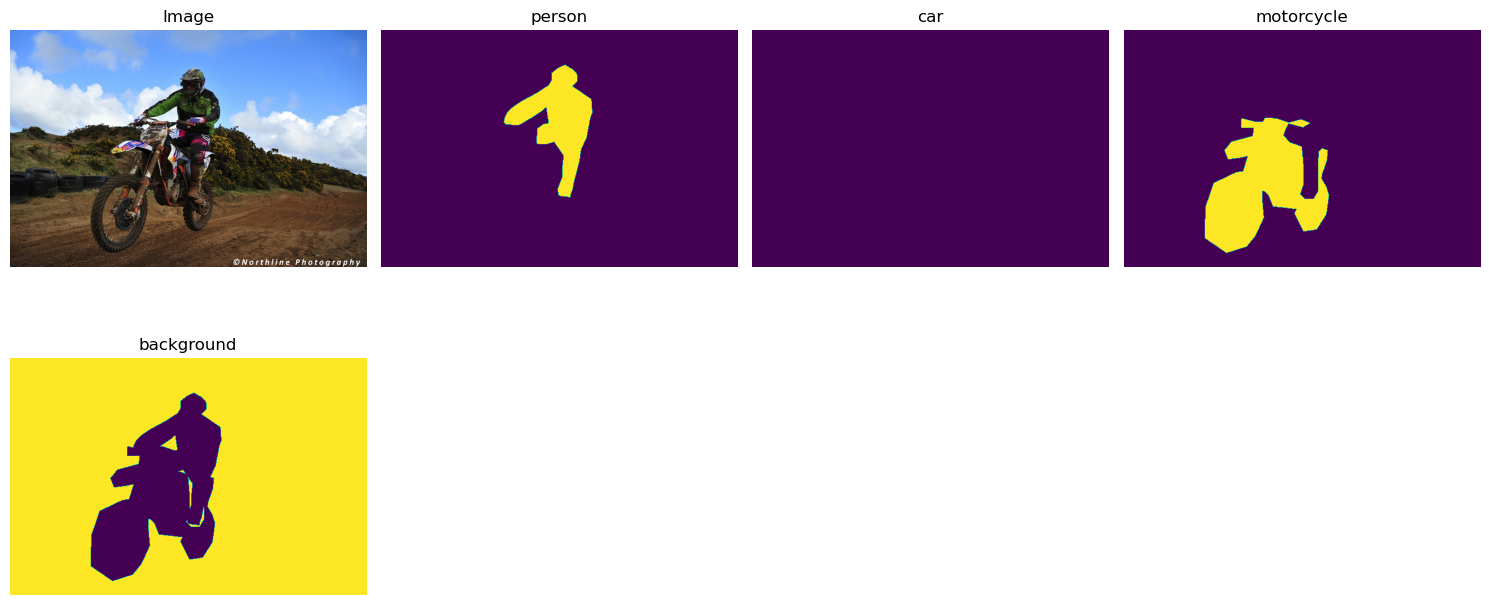

 

Image with id 393230
c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000393230.jpg
mi range is  (480, 640, 4)


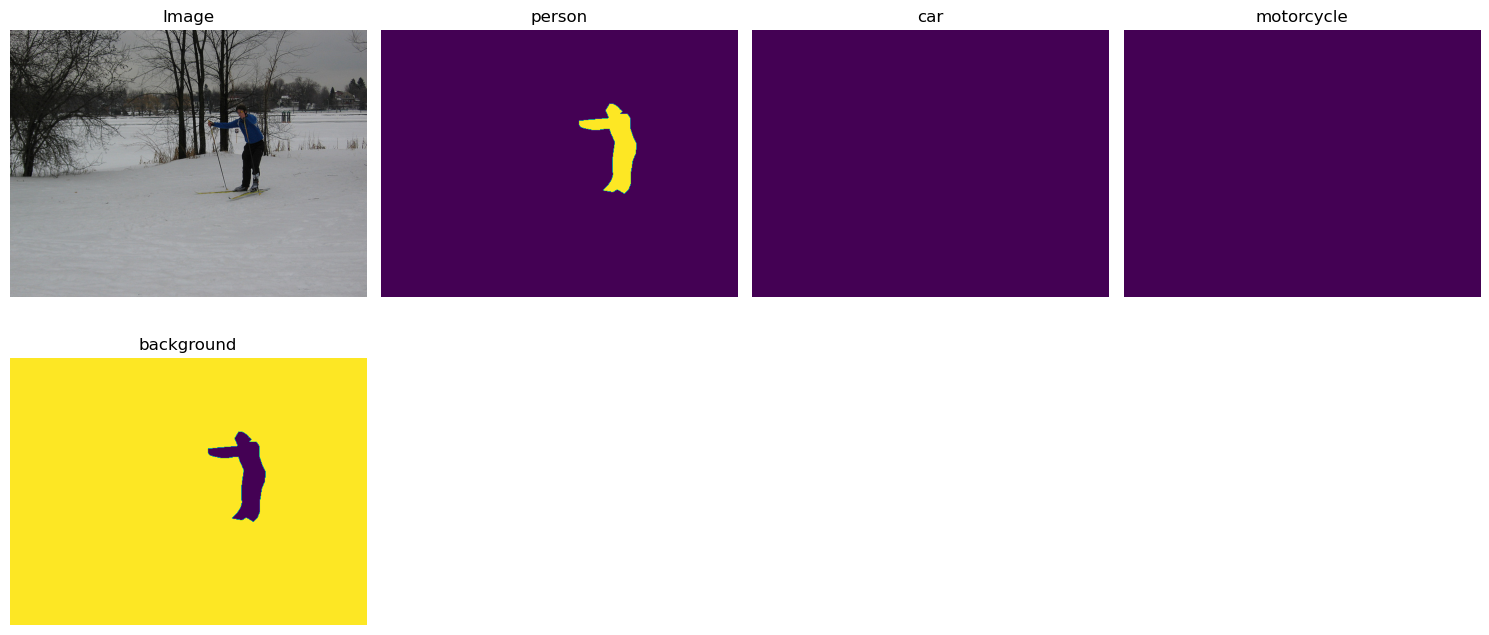

In [32]:


for image, masks in zip(img_ids[:10],results):

    print("Image with id", image)
    
    plot_image_with_masks(image, masks, objetives)
    print(" \n")


Comprobados los resultados, generamos el objeto `tf.dataset` que nos permitirá una carga más rápida en memoria a la hora de entrenar nuetro modelo. Además, este tipo de objetos es más portable de cara a cargarse en un entorno cloud, que podrá ser usado a futuro si se requieren mayores capacidades computacionales, al carecer de GPU.


In [33]:
def data_generator(image_id):


    image_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(TRAIN_IMAGES_PATH, image_info['file_name'])
    original_image = cv2.imread(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    mascaras = []



    background = empty_mask_generator(image_id)


    for cat in category_info_objetive.keys():

        mask = mask_generator(image_id=image_id, class_id= cat, display= False, threshold = 300 )
        background = np.add(background, mask, )

        mascaras.append(mask)

    background = np.where(background!= 0 , 0 , 1)
    mascaras.append(background)

    mascara_imagen = np.stack(mascaras, axis=-1)


    yield original_image, mascara_imagen



In [34]:
def create_tf_dataset(image_ids):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(image_ids),
        output_signature=(
                tf.TensorSpec(shape=(None,None,3),dtype=tf.uint8), 
                tf.TensorSpec(shape=(None,None,N_CLASSES),dtype=tf.uint8)   
        )
    )

    return dataset

Lo guardamos en el path fijado en el fichero `yaml` para posteriormente poder cargarlo de forma cómoda

In [41]:
DATASET_PATH = r"C:\Users\ruben\Desktop\code_tfm\clean_dataset\dataset_v1"

In [42]:

dataset = create_tf_dataset(img_ids)

tf.data.experimental.save(dataset, DATASET_PATH)

In [57]:
COLORS = ['gray', 'red','blue','green','yellow', 'orange','purple','pink', 'brown','cyan','white',"blue"]

COLORS_DICT = {index:color for index, color in enumerate(COLORS)}



def plot_image_with_masks_one_hot_encoded(original_image, masks, dict_colors=COLORS_DICT):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs = axs.flatten()

    axs[0].imshow(original_image)
    axs[0].axis('off')
    axs[0].set_title('Image')

    print("Mask shape:", masks.shape)
    
    composite_mask = np.zeros((masks.shape[0], masks.shape[1]), dtype=np.uint8)

    for idx in range(masks.shape[-1]):
        mask_values = np.where(masks[:, :, idx] != 0, idx, 0)
        composite_mask  = np.add(mask_values,composite_mask )

    axs[1].imshow(composite_mask, cmap='tab10')
    axs[1].axis('off')
    axs[1].set_title('Segmentation Mask')

    # Create legend
    #legend_patches = [mpatches.Patch(color=np.array(color) / 255.0, label=f'Class {idx}') for idx, color in dict_colors.items()]
    #axs[1].legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.show()


my image shape is  (427, 640, 3)
my mask shape is  (427, 640, 4)
Mask shape: (427, 640, 4)


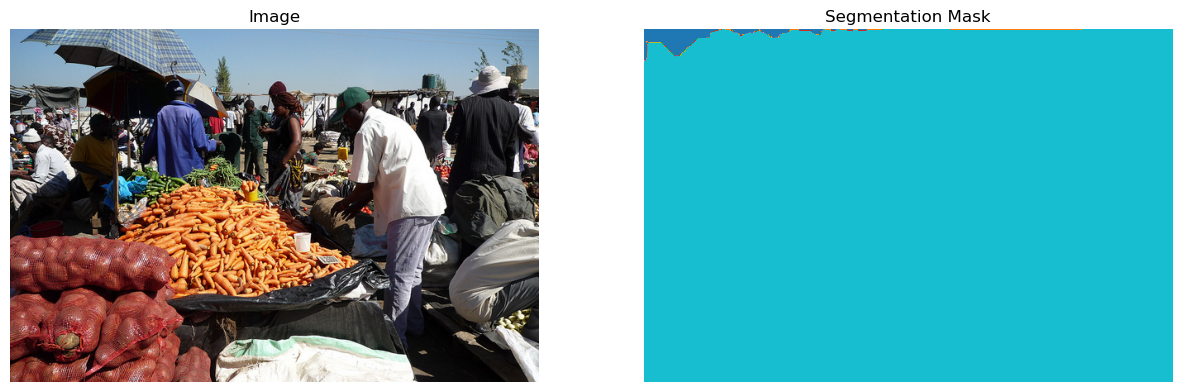

In [59]:
loaded_dataset = tf.data.experimental.load(DATASET_PATH)

for image, mask in loaded_dataset.take(3): 
    print("my image shape is ", image.shape)
    print("my mask shape is ", mask.shape)

    image =image.numpy()
    mask =mask.numpy()

    plot_image_with_masks_one_hot_encoded(image, mask )



### 2. Generación de imágenes derivadas de las actuales

Para aumentar el tamaño del conjunto de entrenamiento y poder obtener un dataset que facilite al modelo la capacidad de generalización, es necesario aplicar una fase de **data augmentation**. En este caso, se ha decidido que las transformaciones a aplicar serán las siguientes:

1. Movimientos de rotacióm
2. Movimientos de translación
3. Cambios de brillo
4. Aplicación de ruido gausiano


In [ ]:

def augment_data(image, mask):
    """
    Applies data augmentation to both the image and mask.
    Handles variable-sized images dynamically.
    
    Args:
    - image: TensorFlow tensor of shape (H, W, C).
    - mask: Corresponding segmentation mask of shape (H, W, num_classes).

    Returns:
    - Augmented image and mask tensors.
    """
    # Random horizontal flip
    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation (0°, 90°, 180°, 270°)
    num_rotations = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=num_rotations)
    mask = tf.image.rot90(mask, k=num_rotations)

    # Random brightness & contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # **Resize dynamically**  
    original_shape = tf.shape(image)[:2]  # (H, W)
    scale = tf.random.uniform([], 0.9, 1.1)  # Random scale factor
    new_shape = tf.cast(tf.cast(original_shape, tf.float32) * scale, tf.int32)

    image = tf.image.resize(image, new_shape, method=tf.image.ResizeMethod.BILINEAR)
    mask = tf.image.resize(mask, new_shape, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # **Random crop/padding back to original size**
    combined = tf.concat([image, mask], axis=-1)
    combined = tf.image.resize_with_crop_or_pad(combined, original_shape[0], original_shape[1])
    image, mask = combined[..., :-tf.shape(mask)[-1]], combined[..., -tf.shape(mask)[-1]:]

    return image, mask


In [ ]:
# Apply augmentations after loading
AUTOTUNE = tf.data.AUTOTUNE
augmented_dataset = dataset.map(augment_data, num_parallel_calls=AUTOTUNE)

# Optimize dataset pipeline
augmented_dataset = augmented_dataset.batch(32).prefetch(AUTOTUNE)

# Iterate over the dataset (example usage)
for images, labels in augmented_dataset.take(1):
    print(images.shape, labels.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_shape=(None, None, 3), num_classes=1):
    """
    Builds a simple U-Net model.

    Args:
    - input_shape: Shape of input images (H, W, C). H and W can be None for variable-sized inputs.
    - num_classes: Number of output segmentation classes.

    Returns:
    - Compiled U-Net model.
    """

    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv4, up6])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax' if num_classes > 1 else 'sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model


In [ ]:
# Load dataset (Assuming dataset contains (image, mask) pairs)
DATASET_PATH = "path_to_dataset"
dataset = tf.data.experimental.load(DATASET_PATH)

# Apply augmentations dynamically
AUTOTUNE = tf.data.AUTOTUNE
augmented_dataset = dataset.map(augment_data, num_parallel_calls=AUTOTUNE)

# Batch and prefetch for efficiency
BATCH_SIZE = 8  # Reduce batch size if memory is an issue
augmented_dataset = augmented_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Split dataset into training and validation
train_size = int(0.8 * 10000)  # Assuming 10,000 images, adjust accordingly
train_dataset = augmented_dataset.take(train_size)
val_dataset = augmented_dataset.skip(train_size)


In [ ]:
# Create the model
model = unet_model(input_shape=(None, None, 3), num_classes=2)  # Change num_classes based on your dataset

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',  # or 'binary_crossentropy' if single class
              metrics=['accuracy'])

# Train the model
EPOCHS = 25
model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=EPOCHS)


In [ ]:
# Save the trained model
model.save("unet_segmentation_model.h5")

# Load a test image (assuming image and mask are tensors)
for img, mask in val_dataset.take(1):
    pred_mask = model.predict(img)

    print(f"Predicted mask shape: {pred_mask.shape}")


In [38]:
def preprocess_data(image, mask):
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    mask = tf.cast(mask, tf.uint8)
    mask = tf.one_hot(mask, depth=5) 
    
    return image, mask

dataset = tf.data.experimental.load(DATASET_PATH)

BATCH_SIZE = 16
dataset = dataset.map(preprocess_data).batch(BATCH_SIZE).shuffle(100)

In [39]:


def unet_model(input_shape=(256, 256, 3), num_classes=5):
    inputs = Input(input_shape)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs, outputs)
    return model


In [40]:
model = unet_model(input_shape=(256, 256, 3), num_classes=5)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 20
model.fit(dataset, epochs=EPOCHS)


Epoch 1/20


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, None, None, 4, 5), output.shape=(None, None, None, 5)

In [ ]:
loss, acc = model.evaluate(dataset)
print(f"Test Accuracy: {acc:.4f}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for image, mask in dataset.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)  

    image = image.numpy()
    mask = tf.argmax(mask, axis=-1).numpy()  

    plt.figure(figsize=(15, 5))
    for i in range(3): 
        plt.subplot(3, 3, i*3+1)
        plt.imshow(image[i])
        plt.title("Original Image")

        plt.subplot(3, 3, i*3+2)
        plt.imshow(mask[i], cmap="jet")
        plt.title("Ground Truth Mask")

        plt.subplot(3, 3, i*3+3)
        plt.imshow(pred_mask[i], cmap="jet")
        plt.title("Predicted Mask")

    plt.show()


### 2. Generación de nuevas imágenes

Para la generación de nuevas imágenes, se aplica la combinación de las siguientes técnicas:
- Rotación
- Escalado
- Traslación
- Volteo horizontal
- Cambios de brillo, contraste, saturación y gamma
- Adición de ruido gaussiano
- Aumentación Basada en Contexto Semántico

### 3. Uso de modelos fundacionales


Además, para el segundo de los modelos, se hace 

In [ ]:
import cv2
import os
import numpy as np
import time
from tqdm import tqdm
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

ModuleNotFoundError: No module named 'segment_anything'